## Pairs Trading

This notebook contains sample code on testing out a pairs strategy using cointegration analysis

### Cointegration

Cointegration anaysis is a technique that is widely used. It can be used to find trading strategies based on the property of mean reversion. Cointegration analysis aims to find a grouping of time series (in this case, closing prices of stocks) that behaves as a stationary, or mean reverting process. When this process is below the mean, we go long. When it's above the mean, we go short the basket.

For financial data, it can be shown that returns are stationary but prices are not (see my R statistics code samples for this). However, we can find linear combination of price processes so that that such combination is stationary. The vector of coefficients we solve for is known as a cointegrating vector.

We will consider all of 2022, which as we know had significant turbulence, which should help our results look not-so-ideal.

In [2]:
import numpy as np
import pandas as pd

# We will uuse statsmodels library which can check for cointegration between 2 series
# coint uses the augmented Engle-Granger two step test
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.coint.html
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS

import yfinance as yf
import seaborn
import matplotlib.pyplot as plt

In [14]:
#Some popular stocks
symbol_list = ['META', 'AMZN', 'AAPL', 'NFLX', 'GOOG', 'TSLA', 'QCOM', 'JPM', 'GS']

data = yf.download(
    symbol_list, 
    start='2022-01-01', 
    end='2023-01-01'
)['Adj Close']

[*********************100%***********************]  9 of 9 completed


In [39]:


##Pairwise cointegration analysis
## O(n^2) algorithm
#TODO: Apply multicointegration, e.g. Phillips-Ouliaris cointegration test
#Can be 0.10 to be more permissive, or 0.025, 0.01 to be more restrictive

def find_cointegrated_pairs(data, alpha_critical = 0.05):
    rows, cols = data.shape
    score_matrix = np.zeros(shape = (cols, cols))
    pvalue_matrix = np.ones(shape = (cols, cols))

    #Note that this returns in alphabetical order. keys[0] is AAPL. symbol_list[0] is META. The yfinance package returns in alphabetical order, openbb will return in the order you give it
    #keep it consistent!
    keys = data.keys()
    pairs = []

    for i in range(cols):
        for j in range(i+1, cols):
            #Extract the two time series
            S1 = data[keys[i]]
            S2 = data[keys[j]]

            #See function spec. result is a tuple of the t-stat, the p-value, and the critical values for the test statistic at 1/5/10 levels
            #TODO: Can improve to use result[2] and a vecotrized check instead of a manual check with alpha_critical
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i,j] = score
            pvalue_matrix[i,j] = pvalue

            if pvalue < alpha_critical:
                pairs.append((keys[i], keys[j]))
        
    return score_matrix, pvalue_matrix, pairs

alpha_critical = 0.05
scores, pvalues, pairs = find_cointegrated_pairs(data, alpha_critical = alpha_critical)

Now that we have our results, let's plot them to visualize it.

We can use a heatmap from seaborn. What we are doing is plotting the pvalues matrix. We are applying a color map to it to visualize the difference in pvalues. In this example, we choose red as the highest values and green as the lowest values. To prevent the whole thing from being colored, we apply a mask to ignore all pvalues above our alpha_critical value.

[('AAPL', 'AMZN'), ('META', 'QCOM')]


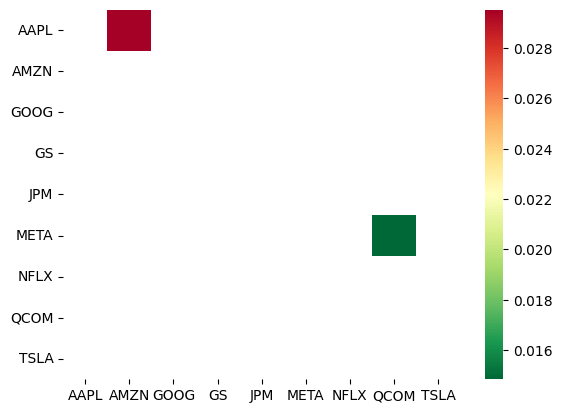

In [43]:
seaborn.heatmap(
    pvalues, 
    xticklabels=keys, 
    yticklabels=keys, 
    cmap='RdYlGn_r', 
    mask = (pvalues >= alpha_critical)
)

print(pairs)

We see that we have two cointegrated series, AMZN/AAPL, and META/QCOM. We see this from our pairs variable and from the plot. NOTE: Remember, we used keys in our function, so we specify keys in the argument for this plot. Had we used symbol_list, we would have incorrect labels that wouldn't match pairs (try it on your end to see).

Let's look more closely at META/QCOM since it has a lower p-value.

In [78]:
# Run a linear regression
S1 = data.META
S2 = data.QCOM

#S1 = sm.add_constant(S1)
#convention: the first stock is independent, the second stock is dependent
results = sm.OLS(S2, sm.add_constant(S1)).fit()

## SEE: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html#statsmodels.regression.linear_model.RegressionResults
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   QCOM   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     779.7
Date:                Sat, 08 Jul 2023   Prob (F-statistic):           1.14e-78
Time:                        23:22:47   Log-Likelihood:                -919.76
No. Observations:                 251   AIC:                             1844.
Df Residuals:                     249   BIC:                             1851.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.5267      1.999     41.285      0.000      78.590      86.464
META           0.2956      0.011     27.924      0.000       0.275       0.316
==============================================================================
Omnibus:                       16.454   Durbin-Watson:                   0.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.018
Skew:                           0.599   Prob(JB):                     0.000202
Kurtosis:                       2.563   Cond. No.                         631.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
print(results.params)

const    82.526662
META      0.295563
dtype: float64


82.52666154799583

How do we interpret these regression results? Again, we regressed META onto QCOM. So, the results say that the price process of QCOM is equal to 0.2955*META + 82.53, assuming it is a linear relationship. In reality it is a nonlinear relationship as we know, but again, no regression is perfect. The adjusted R squared value is far from perfect, but better than average too.

Text(0.5, 0, 'Date')

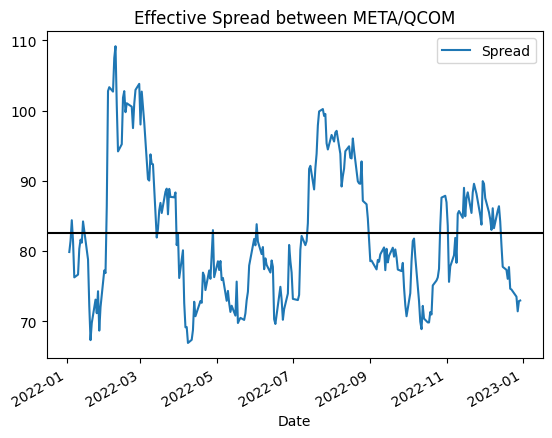

In [79]:
#S1 = S1.META
b = results.params['META']
spread = S2 - b * S1
spread.plot()
#Note that due to the properties of regression, spread.mean() is equal to the constant value from our regression results, about 82.53
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread'])
plt.title('Effective Spread between META/QCOM')
plt.xlabel('Date')

The spread is defined as QCOM - b*META, where b is the coefficient from the regression. Effectively, we are saying that the noise from the regression is the spread.
The problem with the analysis so far is we don't know what is a buy signal and what is a sell signal. We just know when the spread is higher than the mean, and when it's lower than the mean. We need to use a scoring methodology to generate our trade signals.

We'll stick with something simple: Z-scores. These are based on the normal distribution, and they indicate the presence of a statistical outlier. If we are above a 2 or below a -2 zscore, we'll use that as a buy.

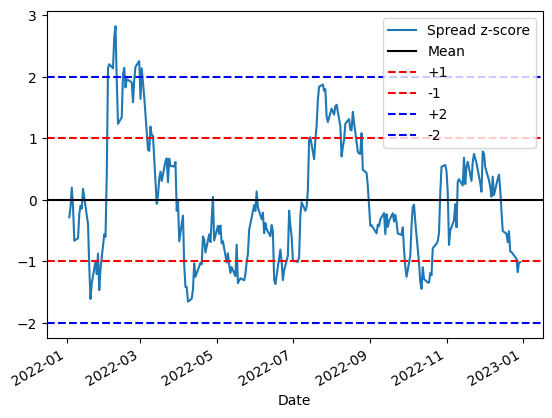

In [53]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='red', linestyle='--')
plt.axhline(2.0, color='blue', linestyle='--')
plt.axhline(-2.0, color='blue', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1', '+2', '-2']);

Unfortunately, we would not have very many buy/sell signals if we want to exceed 2. So let's lower it to 1, which is less precise, but will result in more trades taking place, which can help generate some data for us to analyze.


In [57]:
trades = pd.concat([zscore(spread), spread], axis=1)
trades.columns = ["signal", "position"]
trades["side"] = 0.0

print(trades)

              signal   position  side
Date                                 
2022-01-03 -0.282581  79.857827   0.0
2022-01-04 -0.115328  81.437447   0.0
2022-01-05  0.196791  84.385252   0.0
2022-01-06 -0.118909  81.403621   0.0
2022-01-07 -0.664706  76.248845   0.0
...              ...        ...   ...
2022-12-23 -0.847866  74.518985   0.0
2022-12-27 -0.955792  73.499679   0.0
2022-12-28 -1.176599  71.414270   0.0
2022-12-29 -1.021854  72.875758   0.0
2022-12-30 -1.013905  72.950831   0.0

[251 rows x 3 columns]


In [65]:
#This is NOT FIX Tag side. This is used for computation of our PNL
#If the spread is low, go long (buy), side = 1. If it's high, go short (side is -1). Otherwise do nothing.
trades.loc[trades.signal <= -1, "side"] = 1
trades.loc[trades.signal >= 1, "side"] = -1

print(trades[trades["side"] == 1])

              signal   position  side
Date                                 
2022-01-19 -1.095200  72.183043   1.0
2022-01-20 -1.611132  67.310320   1.0
2022-01-21 -1.352715  69.750939   1.0
2022-01-24 -1.000240  73.079895   1.0
2022-01-25 -1.205003  71.146003   1.0
2022-01-27 -1.467364  68.668135   1.0
2022-01-28 -1.114690  71.998966   1.0
2022-04-05 -1.050238  72.607687   1.0
2022-04-06 -1.417858  69.135702   1.0
2022-04-07 -1.413066  69.180954   1.0
2022-04-08 -1.653574  66.909475   1.0
2022-04-11 -1.606505  67.354024   1.0
2022-04-12 -1.458905  68.748031   1.0
2022-04-13 -1.032464  72.775548   1.0
2022-04-14 -1.250739  70.714057   1.0
2022-04-18 -1.021623  72.877943   1.0
2022-04-19 -1.048566  72.623474   1.0
2022-05-09 -1.017986  72.912285   1.0
2022-05-11 -1.053370  72.578105   1.0
2022-05-12 -1.186053  71.324976   1.0
2022-05-13 -1.092381  72.209670   1.0
2022-05-16 -1.241604  70.800332   1.0
2022-05-18 -1.352953  69.748689   1.0
2022-05-19 -1.310894  70.145917   1.0
2022-05-20 -

<Axes: xlabel='Date'>

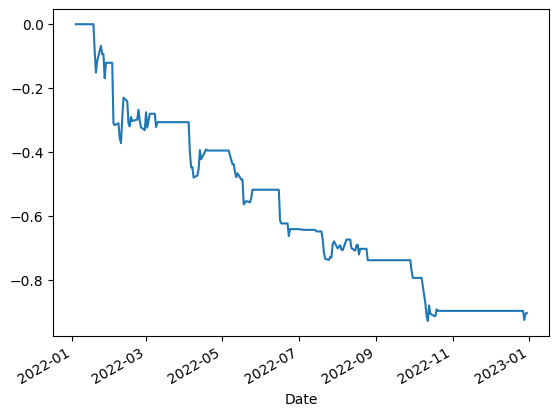

In [75]:
returns = trades.position.pct_change() * trades.side
theoretical = 100 *(1+returns)
returns.cumsum().plot()
#theoretical.plot()

In [71]:
returns = trades.position.pct_change() * trades.side

In [76]:
returns.cumsum()

Date
2022-01-03         NaN
2022-01-04    0.000000
2022-01-05    0.000000
2022-01-06    0.000000
2022-01-07    0.000000
                ...   
2022-12-23   -0.897261
2022-12-27   -0.897261
2022-12-28   -0.925634
2022-12-29   -0.905169
2022-12-30   -0.904139
Length: 251, dtype: float64

Date
2022-01-03           NaN
2022-01-04    100.000000
2022-01-05    100.000000
2022-01-06    100.000000
2022-01-07    100.000000
                 ...    
2022-12-23    100.000000
2022-12-27    100.000000
2022-12-28     97.162696
2022-12-29    102.046492
2022-12-30    100.103016
Length: 251, dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   QCOM   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     779.7
Date:                Sat, 08 Jul 2023   Prob (F-statistic):           1.14e-78
Time:                        23:22:18   Log-Likelihood:                -919.76
No. Observations:                 251   AIC:                             1844.
Df Residuals:                     249   BIC:                             1851.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.5267      1.999     41.285      0.000      78.590      86.464
META           0.2956      0.011     27.924      0.000       0.275       0.316
==============================================================================
Omnibus:                       16.454   Durbin-Watson:                   0.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.018
Skew:                           0.599   Prob(JB):                     0.000202
Kurtosis:                       2.563   Cond. No.                         631.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""